<div style="text-align: center; margin-top: 50px; margin-bottom: 30px;">
    <h1 style="font-size: 3em; color:#00E0FF;">Payment Analysis Test Case</h1>
    <h3 style="font-size: 2em; color: #E3BD00;">Clesson Roberto da Silva Junior</h3>
    
</div>

---

## Description

In this analysis, I will use Python to process and analyze the data, extracting as much information as possible. Subsequently, I will heavily research and implement the best machine learning model to predict fraud.


- Things to watch for:

  - Latency
  - Security
  - Architecture
  - Coding style

- Antifraud Requirements
  - Reject transaction if user is trying **too many transactions in a row**;
    - Search for usual number used for this;
  - Reject transactions above a **certain amount in a given period**;
    - Try to find common values in fraudster transactions and times where fraud is more likely to occur.
  - Reject transaction **if a user had a chargeback before** (note that this information does not comes on the payload. The chargeback data is received days after the transaction was approved)
    - The card has been "canceled", so there is no reason to accept a transaction.


From all my previous experiences, the Google Framework is the best way to analyze data. But how it works? 

## Google Analytics Steps

<ol style="font-size: 1.2em; color: #F3CF1D; line-height: 1.5;">
  <li><strong>Ask</strong> - Define the questions you want to answer.</li>
  <li><strong>Prepare</strong> - Collect and prepare your data for analysis.</li>
  <li><strong>Process</strong> - Clean and transform the data to ensure accuracy.</li>
  <li><strong>Analyze</strong> - Examine the data to find insights and patterns.</li>
  <li><strong>Share</strong> - Present your findings to stakeholders.</li>
  <li><strong>Act</strong> - Make decisions and take actions based on the analysis.</li>
</ol>

So, let's get into our first section, to ask the questions.

---

## <span style="color:#F7A454">1. Asking the questions</span>


## Common Findings in Fraud Detection

Here are some of the most common findings when identifying fraud in credit card data:

1. **Unusual Transaction Amounts**: Transactions that are significantly higher or lower than the average transaction amounts.
2. **Multiple Transactions in a Short Time Frame**: Numerous transactions occurring within a very short period.
3. **Transactions from Different Geographic Locations**: Transactions made from locations that are significantly different from the cardholder’s usual locations.
4. **Inconsistent Merchant Categories**: Purchases from merchant categories that are unusual for the cardholder.
5. **Odd Hours Transactions**: Transactions made at times that are unusual for the cardholder.
6. **Frequent Chargebacks**: A high number of chargebacks associated with the cardholder's account.

### Key Questions to Ask:

1. **Are there any transactions that significantly deviate from the cardholder’s typical spending patterns?**
2. **Are there clusters of transactions occurring in a very short period?**
3. **Do any transactions originate from geographic locations far from the cardholder’s usual area?**
4. **Are there purchases from merchant categories that are atypical for the cardholder?**
5. **Do any transactions occur at odd hours, compared to the cardholder’s normal activity?**
6. **Is there a high frequency of chargebacks, and what are the reasons for these chargebacks?**

Not all the questions must be answered perfectly, but now I've a guide. **So, let's prepare the data.**

---

## <span style="color:#F7A454">2. Preparing the data.</span>

#### Importing Lib's

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

#### Taking a look at the data

In [15]:
df = pd.read_csv('transactions.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())


   transaction_id  merchant_id  user_id       card_number  \
0        21320398        29744    97051  434505******9116   
1        21320399        92895     2708  444456******4210   
2        21320400        47759    14777  425850******7024   
3        21320401        68657    69758  464296******3991   
4        21320402        54075    64367  650487******6116   

             transaction_date  transaction_amount  device_id  has_cbk  
0  2019-12-01T23:16:32.812632              374.56   285475.0    False  
1  2019-12-01T22:45:37.873639              734.87   497105.0     True  
2  2019-12-01T22:22:43.021495              760.36        NaN    False  
3  2019-12-01T21:59:19.797129             2556.13        NaN     True  
4  2019-12-01T21:30:53.347051               55.36   860232.0    False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----

In [16]:
num_cbk_true = df[df['has_cbk'] == True].shape[0]
print("Number of rows with 'has_cbk' = True:", num_cbk_true)

Number of rows with 'has_cbk' = True: 391


### Brief Analysis

I have the common practice of looking at the absolutely raw data and making a quick analysis, here is what I found out.

The card number is currently masked with asterisks, which hinders its usability. I will remove the asterisks to make the data more accessible for analysis.

Regarding the null values in the device_id column, this anomaly warrants further investigation. It is possible that individuals with null device IDs may be either important users who prioritize their device privacy or potential fraudsters attempting to conceal their identity. This aspect requires deeper analysis to discern patterns and potential implications.

The std is higher than the mean in the "transaction_amount" column, so the amount variability is high. So these questions come to mind:
 - Are there any specific transaction amounts or ranges that are more common or less common? 
 - Are there any outliers in transaction amounts that warrant further investigation?

Transaction data is an object, convert it to time frame

It's a common practice in carding (the act of using fraudulent credit cards), a common tactic involves attempting multiple cards with altered details but under the same merchant ID. This practice is aimed at impersonating different individuals while maintaining consistency with the merchant. To detect potential instances of this, I will analyze transactions with similar amounts occurring within the same merchant and occurring within a short timeframe, approximately 30 minutes. If a specific merchant has a lot of fraudulents attemps (chargebacks) it may indicate some infosec problem.

Very low amounts may also indicate that a hacker is trying to test if the stolen CC info is working or not.

Cluster plot the merchant id

The number of "fraudlent" transactions is very tiny for a ML model to obtain useful performance, so **augmentation** may be necessary.

Plot only the fraudlent transactions by time of the day.


---

## <span style="color:#F7A454">3. Processing the data.</span>

In [17]:
# Removing asterisk from CC info
df['card_number'] = df['card_number'].str.replace('*', '')
df['card_number'] = df['card_number'].astype('int64')
#? Converting date to datetime, I'll separate the date and time.
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_day'] = pd.to_datetime(df['transaction_date'].dt.date) #? Converting to datetime

df['transaction_time'] = df['transaction_date'].dt.time
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S.%f')#? Converting to datetime
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   int64         
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
 8   transaction_day     3199 non-null   datetime64[ns]
 9   transaction_time    3199 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(2), int64(4)
memory usage: 228.2 KB
None


C:\Users\PC\AppData\Local\Temp\ipykernel_6496\3320557203.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['card_number'] = df['card_number'].str.replace('*', '')


Now that the data has been cleaned, let's understand it.

## <span style="color:#F7A454">4. Analyzing the data.</span>

#### Transaction Frequency over time.
Let's check transactions flow through the year.

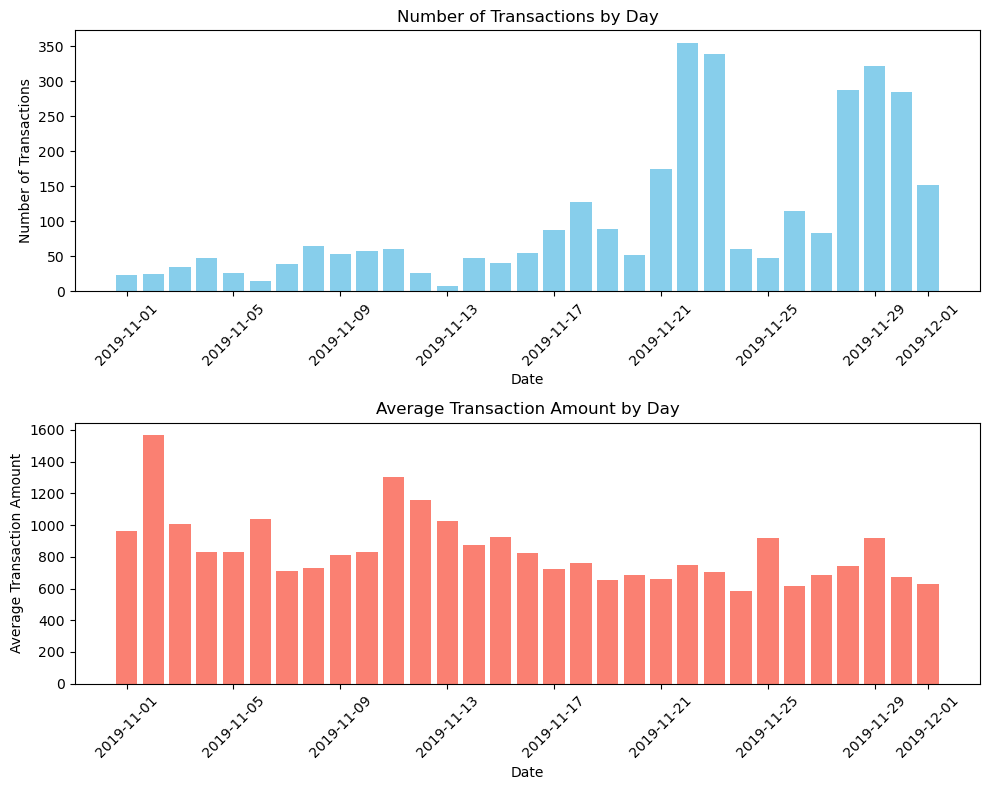

In [29]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

transactions_by_day = df.groupby('transaction_day').size()
axes[0].bar(transactions_by_day.index, transactions_by_day.values, color='skyblue')
axes[0].set_title('Number of Transactions by Day')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Transactions')
# Rotate x-axis labels for better readability
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels


# Plot the average transaction amount by day
average_amount_by_day = df.groupby('transaction_day')['transaction_amount'].mean()
axes[1].bar(average_amount_by_day.index, average_amount_by_day.values, color='salmon')
axes[1].set_title('Average Transaction Amount by Day')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Transaction Amount')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


- The data is in a tight timeframe 2019-11-01 -> 2019-12-01, almost a full month of transactions

- At 2019-11-22, 2019-11-23 -> 56th anniversary of the assassination of President John F. Kennedy in Dallas, Texas, but it doesn't seems to able to create such volume, very strange.

- 2019-11-28, 2019-11-29, 2019-11-30 -> Possibly thanksgiving day, hence the big volume, but it needs further investigation. (I'm possibly considering this data comes from the USA)

- Unusual high average transcation amount at:
  - 2019-11-02 -> No reason
  - 2019-11-05 -> No reason
  - 2019-11-11 -> Veterans Day in the United States



### Transaction Amount Distribution

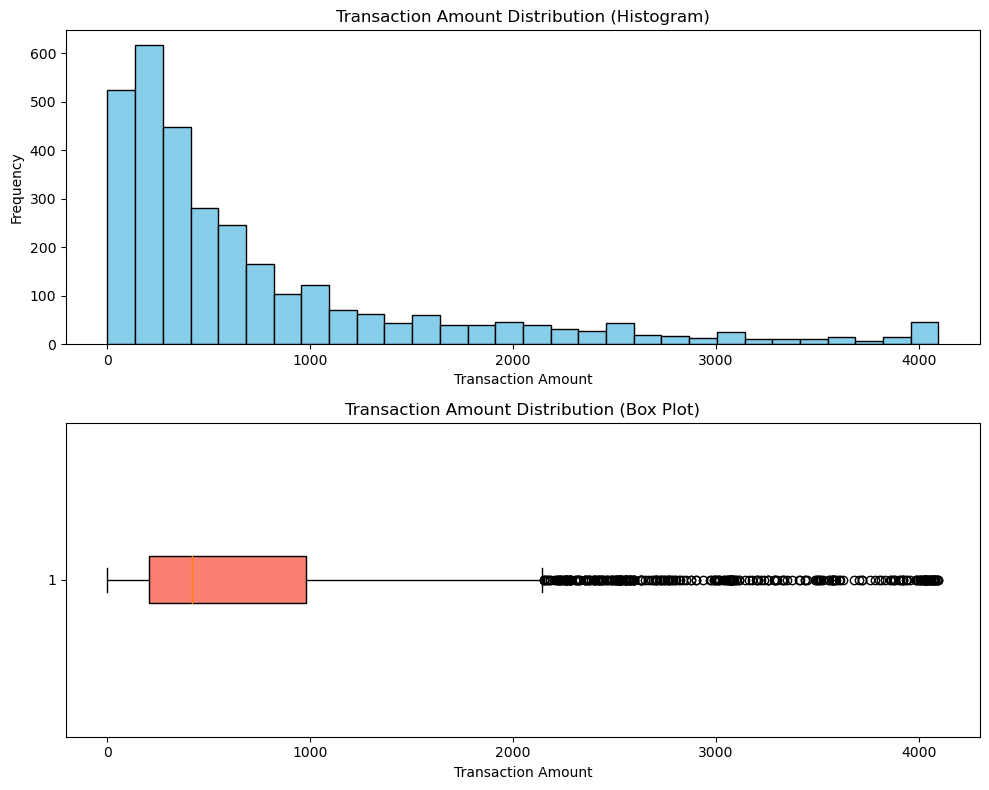

Mean Transaction Amount: 767.8129040325101
Median Transaction Amount: 415.94
Standard Deviation of Transaction Amount: 889.0959040800284


In [30]:
# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram of transaction amounts
axes[0].hist(df['transaction_amount'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Transaction Amount Distribution (Histogram)')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')

# Plot box plot of transaction amounts
axes[1].boxplot(df['transaction_amount'], vert=False, patch_artist=True, boxprops=dict(facecolor='salmon'))
axes[1].set_title('Transaction Amount Distribution (Box Plot)')
axes[1].set_xlabel('Transaction Amount')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Calculate summary statistics
mean_transaction_amount = df['transaction_amount'].mean()
median_transaction_amount = df['transaction_amount'].median()
std_transaction_amount = df['transaction_amount'].std()

print(f"Mean Transaction Amount: {mean_transaction_amount}")
print(f"Median Transaction Amount: {median_transaction_amount}")
print(f"Standard Deviation of Transaction Amount: {std_transaction_amount}")


There are a ton of "outlier" transactions, and transactions between 3000 and 4000 seems to not be quite common. 
